In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 4.29 μs


In [3]:
# configuration settings
data_root = '../data/Emory-4DCT'
mask_roi = 'lung_regions'
mesh_radius = 10
num_levels = 3
num_conv_layers = 2
conv_channels = 8
conv_kernel_size = 3
output_func = 'relu'
batch_size = 1
learning_rate = 1e-5

save_every = 10
save_prefix = '2024-11-06__4dct'
#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'
load_epoch = 0

In [4]:
%autoreload
train_images = project.imaging.Emory4DCT(data_root, phases=range(10, 100, 10))
test_images = project.imaging.Emory4DCT(data_root, phases=[0])
train_images, test_images

(Emory4DCT('../data/Emory-4DCT', 10 cases),
 Emory4DCT('../data/Emory-4DCT', 10 cases))

In [5]:
train_examples = train_images.get_examples(mask_roi, mesh_radius)
test_examples = test_images.get_examples(mask_roi, mesh_radius)
len(train_examples), len(test_examples)

(90, 10)

In [6]:
%autoreload
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [7]:
model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
).cuda()

In [11]:
%autoreload
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    save_every=save_every,
    save_prefix=save_prefix,
    sync_cuda=True
)

In [12]:
if load_epoch:
    trainer.load_state(epoch=load_epoch)

Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T00/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T00_lung_regions_10.xdmf... 23529
['case2_T00.nii'].

<IPython.core.display.Javascript object>


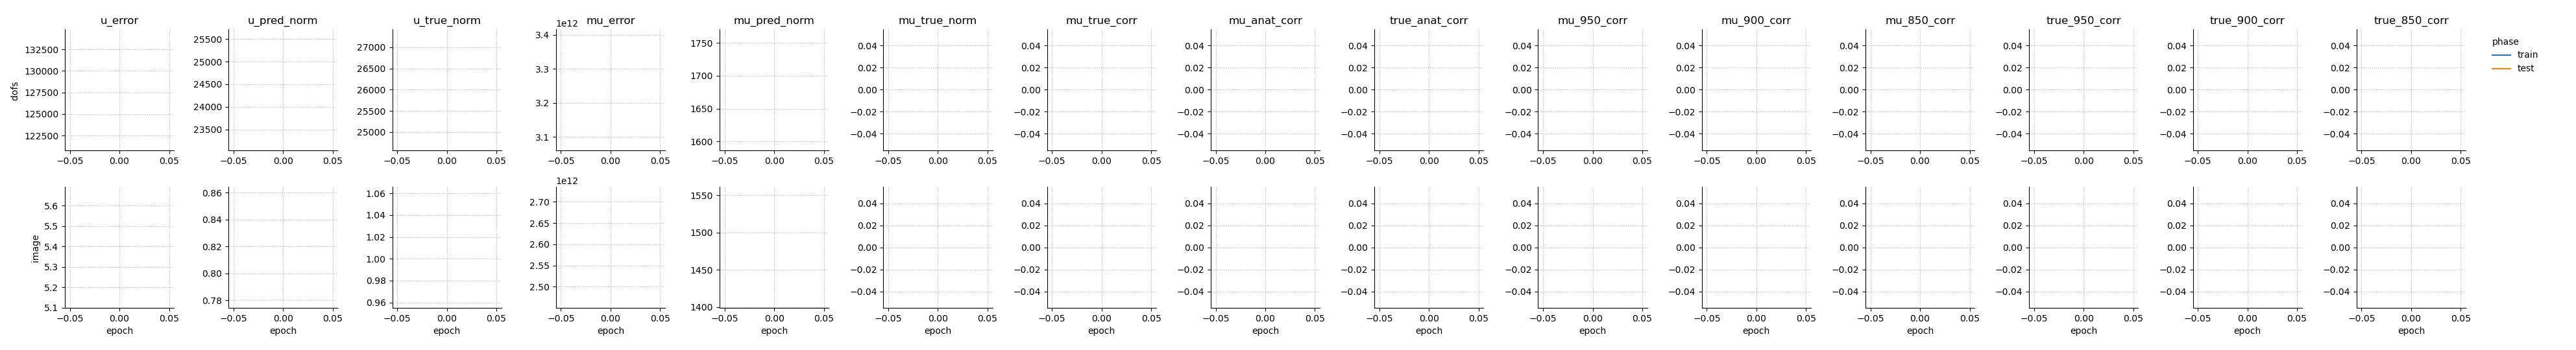

anat


<IPython.core.display.Javascript object>


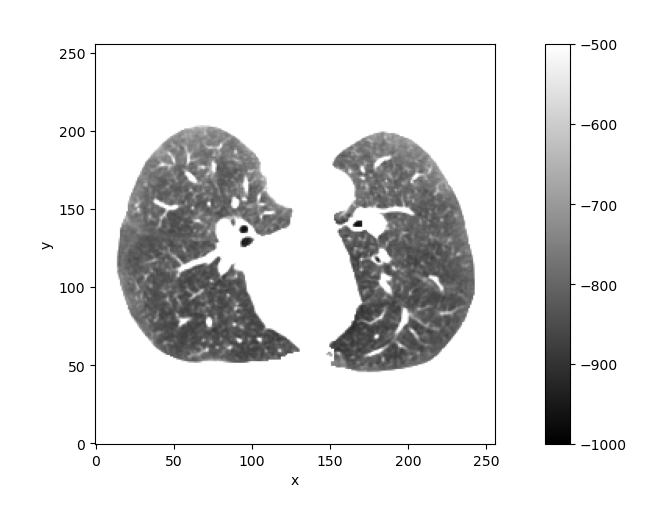

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

emph


<IPython.core.display.Javascript object>


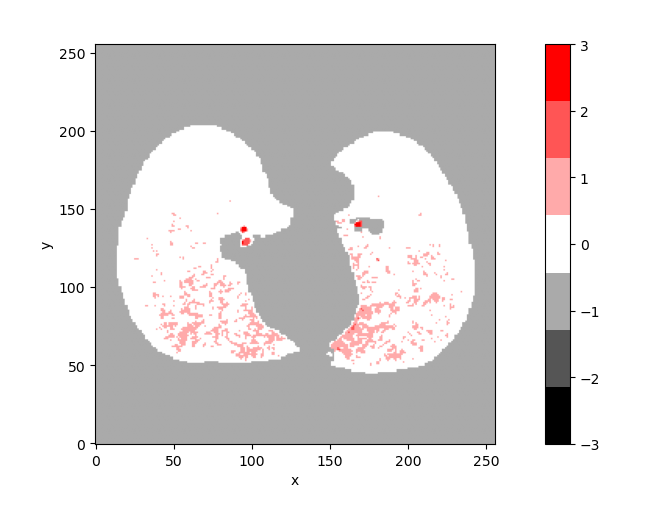

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

e_pred


<IPython.core.display.Javascript object>


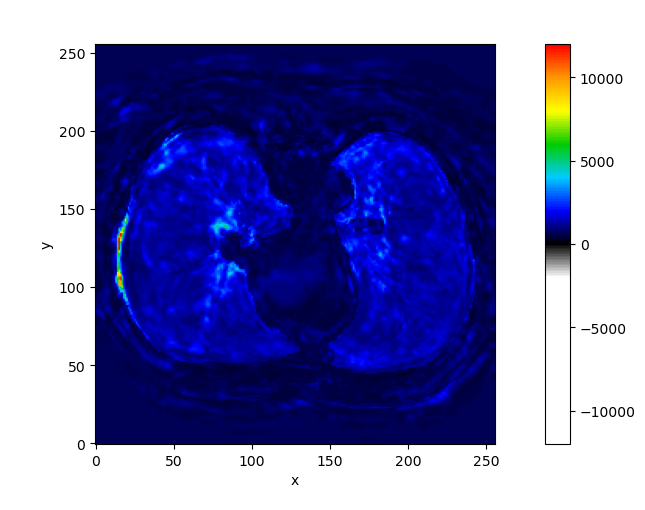

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

e_true


<IPython.core.display.Javascript object>


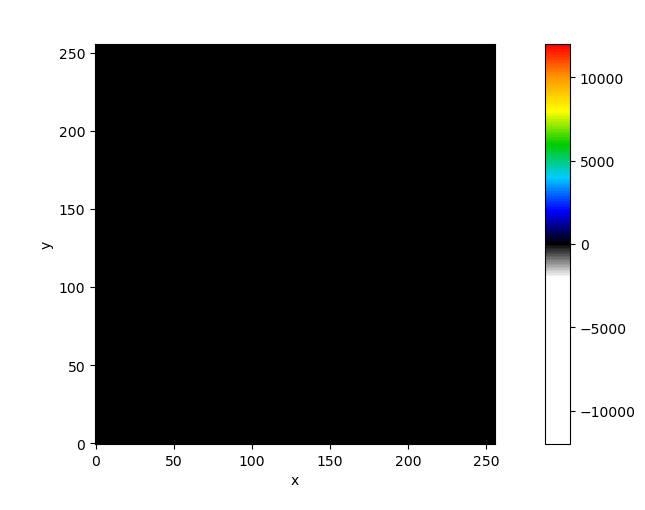

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

u_pred


<IPython.core.display.Javascript object>


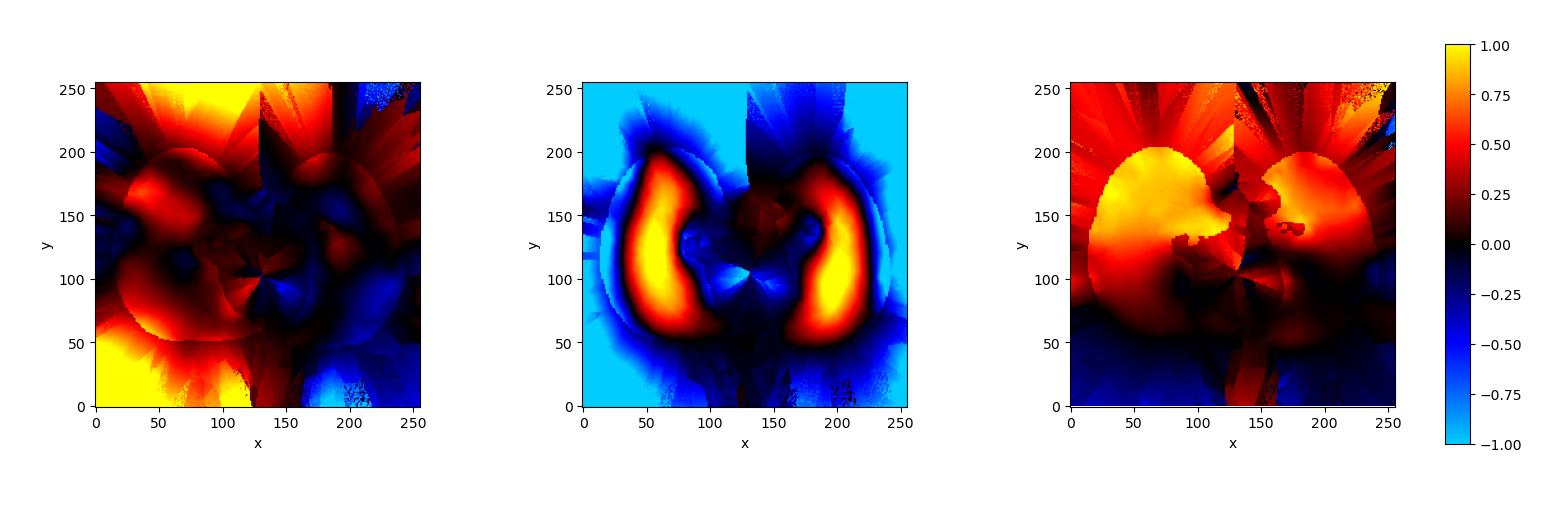

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

u_true


<IPython.core.display.Javascript object>


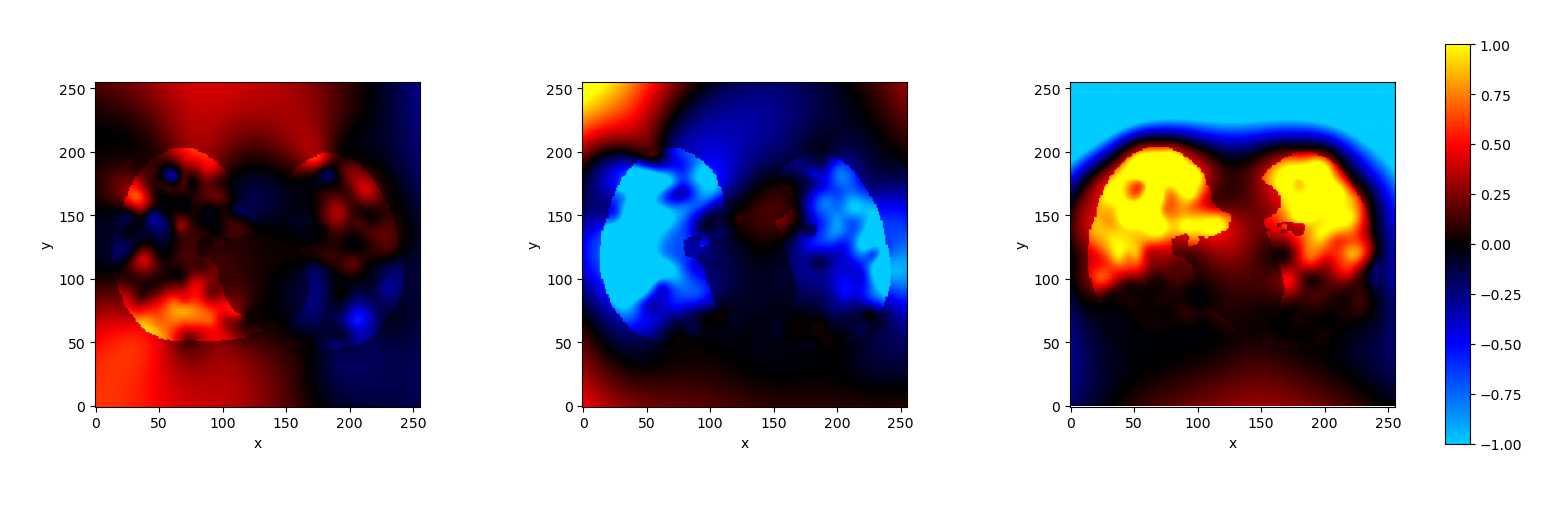

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

127820.2062
CPU times: user 3min 34s, sys: 26.4 s, total: 4min 1s
Wall time: 3min 57s


In [13]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=0)

In [14]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=100)

Training...
Epoch 1/100
Running train phase
Loading ../data/Emory-4DCT/Case7Pack/NIFTI/case7_T40.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case7Pack/CorrField/case7_T50_T40.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T40/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T40_lung_regions_10.xdmf... 25708
['case7_T40.nii'].76845.9950
Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T40.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/CorrField/case6_T50_T40.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T40/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T40_lung_regions_10.xdmf... 32530
['case6_T40.nii'].1155412.4526
Loading ../data/Emory-4DCT/Case8Deploy/NIFTI/case8_T30.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T40_T30.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory

Loading ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T20/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T20_lung_regions_10.xdmf... 31822
['case6_T20.nii'].377530.7650
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T30.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case3Pack/CorrField/case3_T40_T30.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/case3_T30/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T30_lung_regions_10.xdmf... 26132
['case3_T30.nii'].316952.4589
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T70.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T80_T70.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T70/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T70_lung_regions_10.xdmf... 25412
['case2_T70.nii'].1453857.3631
Loading ../data/Emor

['case2_T10.nii'].859820.7821
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T40.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/CorrField/case5_T50_T40.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case5Pack/TotalSegment/case5_T40/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T40_lung_regions_10.xdmf... 17336
['case5_T40.nii'].343759.2345
Loading ../data/Emory-4DCT/Case7Pack/NIFTI/case7_T90.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case7Pack/CorrField/case7_T00_T90.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T90/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T90_lung_regions_10.xdmf... 24474
['case7_T90.nii'].301643.3377
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T20_T10.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/To

Loading ../data/Emory-4DCT/Case9Pack/pygalmesh/case9_T80_lung_regions_10.xdmf... 17133
['case9_T80.nii'].85337.2868
Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T80.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/CorrField/case6_T90_T80.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T80/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T80_lung_regions_10.xdmf... 33260
['case6_T80.nii'].6752.2835
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T60_T50.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T50_lung_regions_10.xdmf... 10065
['case1_T50.nii'].183668.8999
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrFie

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
trainer.timer.usage.reset_index()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

t = trainer.timer.usage.reset_index()

fig, ax = plt.subplots()
sns.lineplot(t[t.phase == 'train'], y='mem_used', x='batch')
fig.tight_layout()

In [ ]:


fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
test_data[0][-5].mean()